
<span style="font-size:2em;">Exploratory Data Analysis:  Has Bankruptcy Become a Crisis in Poland?</span>

This is a summary of some exploratory data analysis that was completed towards answering the question, Has Bankruptcy Become a Crisis in Poland.  There are three supporting questions that are considered below:

- Is it really true that the bankruptcy rate in Poland has increased over the five-year period from 2008-2012?
- If so, what factors may be causing the increase in the bankruptcy rate in Poland?
- Could accurate reporting of financial records provide significant information to help some businesses from not declaring bankruptcy?


The first task is to run the data file.

In [17]:
import requests
import zipfile
import io
import ssl
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
from os import path
import matplotlib.pyplot as plt
import seaborn as sns

#open .arff file if it exists in directory or fetch it from the web
arff_file = '5year.arff'

if path.exists(arff_file) == False:
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip'
    r = requests.get(url)
    textfile = zipfile.ZipFile(io.BytesIO(r.content))
    textfile.extract(arff_file)

file = open(arff_file, 'r')
filedata = file.read()
filedata = filedata.replace('class {0,1}','Attr65 numeric')

file = open(arff_file, 'w')
file.write(filedata)
file.close()

#Convert .arff file to a dataframe
data = loadarff(arff_file)
df = pd.DataFrame(data[0])

# Show relavant statistics
allStats = df.describe(include='all')

# Show relevant statistics with outliers removed
df_NO = df.loc[:,'Attr1':'Attr64']
df_NO = df_NO[(df_NO >= df_NO.mean()-2*df_NO.std()) &
                        (df_NO <= df_NO.mean()+2*df_NO.std())]
df_NO['Target'] = df['Attr65']
allStats_NO = df_NO.describe(include='all')

#Fill all missing values with the mean (df1)
df1 = df_NO.fillna(df_NO.mean())

#Remove rows with any Nan values (df2)
df2 = df_NO.dropna().reset_index(drop=True)

# Choose new dataframe to be df1 or df2
df_NO = df1

#Show correlation matrix to see if Attr37 is highly correlated with anything
corrMat = df_NO.corr()
corrMat['Target'].nsmallest(1), corrMat['Target'].nlargest(2)

# Create a dataframe of attributes and their meanings
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url = 'https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data'
url_get = requests.get(url)
soup = BeautifulSoup(url_get.content, 'lxml')
with open('attributes.txt', 'w', encoding='utf-8') as f_out:
    f_out.write(soup.prettify())
    f_out.close()

with open("attributes.txt", "r") as f:
    lines = f.readlines()
    lines = lines[367:494]
    f.close()
    
finance_def_df = pd.DataFrame({'expression':lines})
finance_def_df = finance_def_df[finance_def_df.index%2 == 0]
finance_def_df = finance_def_df.replace('^\s{6}X[0-9]+\t','',regex=True)\
.replace('$\n','',regex=True)
finance_def_df.index = df.loc[:,'Attr1':'Attr64'].columns

# Create DataFrame of strong correlations (negative and positive) based on correlation threshold
strongCorrMatrix = corrMat.unstack().reset_index()
strongCorrMatrix.rename(columns={'level_0':'Pair1',
                                 'level_1':'Pair2',0:'Correlation'}, inplace=True)
corrThresh = 0.90
strongCorrMatrix = strongCorrMatrix[((strongCorrMatrix['Correlation'] >= corrThresh) |
        (strongCorrMatrix['Correlation'] <= -corrThresh)) &
        (strongCorrMatrix['Pair1'] != strongCorrMatrix['Pair2'])]
strongCorrMatrix.reset_index(drop=True, inplace=True)

Early signs may point to an increase in bankruptcy of Polish companies from 2008-2012.

Text(0.5, 1.0, 'Polish Bankruptcy Percentage by Year')

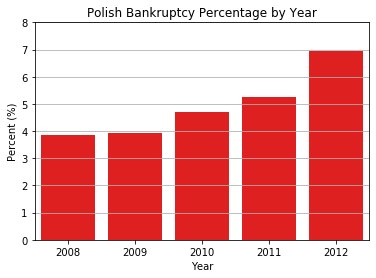

In [18]:
bankrupt_companies = np.array([271,400,495,515,410])
total_companies = np.array([7027,10173,10503,9792,5910])
bankrupt_percentage = bankrupt_companies/total_companies*100
sns.barplot([2008,2009,2010,2011,2012],bankrupt_percentage, color='red')
plt.grid(axis='y')
plt.ylim(0,8)
plt.xlabel('Year')
plt.ylabel('Percent (%)')
plt.title('Polish Bankruptcy Percentage by Year')

Taking a look at the correlation distribution by year of how a company’s bankruptcy filing decision is correlated with the reported financial attributes, it is evident that there is relatively low correlation.  The tails of the distribution (showing the highest magnitude of correlation are below 0.15. 

(Please note that, for brevity, the plotting code for distributions between 2008-2011 are found in each file 1arff.py, 2arff.py, 3arff.py, and 4arff.py.  The 2012 plotting code is below.  The file listed have the same plotting code as the 2012 distribution.)

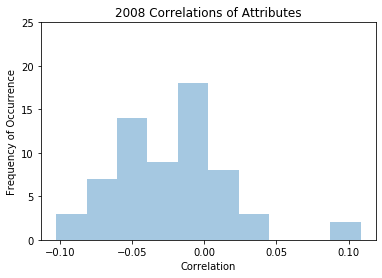

In [19]:
def year_correlation_dist(filename):
    exec(open(filename).read())
    
year_correlation_dist('1arff.py')

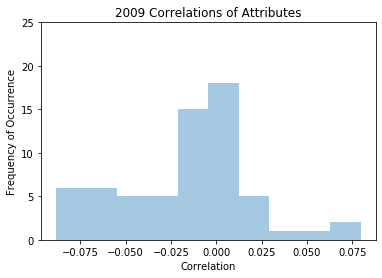

In [20]:
year_correlation_dist('2arff.py')

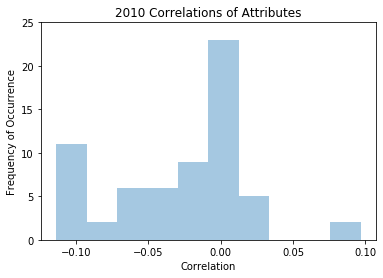

In [21]:
year_correlation_dist('3arff.py')

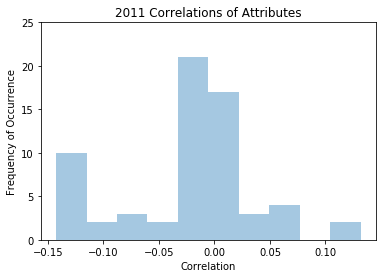

In [22]:
year_correlation_dist('4arff.py')

However, the 2012 correlation distribution shows increased correlation magnitudes.  Although it is still relatively low, it is worth investigating what financial attributes may be contributing to this increase.

Text(0.5, 1.0, '2012 Correlations of Attributes')

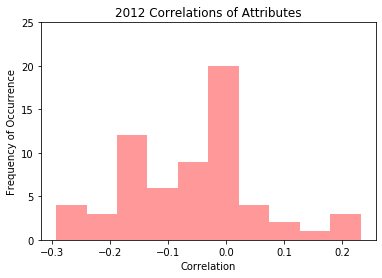

In [23]:
sns.distplot(corrMat['Target'][corrMat['Target'] != 1],bins=10,kde=False,norm_hist=False, color='red')
plt.ylim(0,25)
plt.xlabel('Correlation')
plt.ylabel('Frequency of Occurrence')
plt.title('2012 Correlations of Attributes')

The top ten financial attributes and their correlation magnitudes are plotted below.  Financial attributes 39, 25, 35, and 38 have interestingly much larger correlation magnitudes.  But what are these attributes?

Note that the blue bars represent positive correlation and the red bars represent negative correlation.

Text(0.5, 1.0, 'Correlation Magnitudes by Attributes')

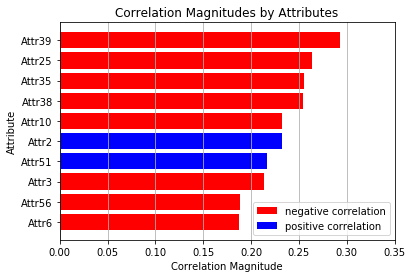

In [24]:
top_ten = corrMat[['Target']][(corrMat['Target']) != 1]
top_ten['mag'] = abs(top_ten.Target)
top_ten = top_ten.nlargest(10, columns=['mag'])
top_ten['neg'] = np.where(top_ten.Target < 0, top_ten.mag, 0)
top_ten['pos'] = np.where(top_ten.Target > 0, top_ten.mag, 0)
top_ten = top_ten.sort_values('mag', ascending=True)

plt.barh(top_ten.index, top_ten.neg, color='red', label='negative correlation')
plt.barh(top_ten.index, top_ten.pos, color='blue', label='positive correlation')
plt.legend()
plt.grid(axis='x')
plt.xlim(0,0.35)
plt.xlabel('Correlation Magnitude')
plt.ylabel('Attribute')
plt.title('Correlation Magnitudes by Attributes')

The definitions for the top ten attributes with the highest correlation magnitudes are shown below in the table.  After careful analysis, there seems to be a trend that all of the definitions are inversely proportional to total assets and sales.  In fact, 80% of the top ten financial attribute definitions are inversely proportional to total assets while the othe 20% are inversely proportional to sales.  Perhaps, total assets and sales are important factors n predicting if a company files for bankruptcy.

In [25]:
top_ten = top_ten.sort_values('mag', ascending=False)
top_ten_att = pd.DataFrame({'Definition':[finance_def_df.loc[i,'expression'] for i in top_ten.index]}, index=top_ten.index)
print(top_ten_att)

                                     Definition
Attr39                  profit on sales / sales
Attr25  (equity - share capital) / total assets
Attr35           profit on sales / total assets
Attr38          constant capital / total assets
Attr10                    equity / total assets
Attr2          total liabilities / total assets
Attr51    short-term liabilities / total assets
Attr3            working capital / total assets
Attr56  (sales - cost of products sold) / sales
Attr6          retained earnings / total assets


Further, during exploration, a trend was noticed that financial attributes 7, 14, and 18 seem to have the same data.  To investigate this observation, the data were plotted in pairs against each other (Attr7 vs Attr14, Attr7 vs Attr18, and Attr14 vs Attr18) and fitted with a regression line to test the similarity of the data.  Each of the slopes are approximately equal to 1, and each of the y-intercepts are approximately equal to 0; as such, this seems to confirm that these data columns are essentially the same.

Slope = 0.999985 and y-intercept = 0.000026


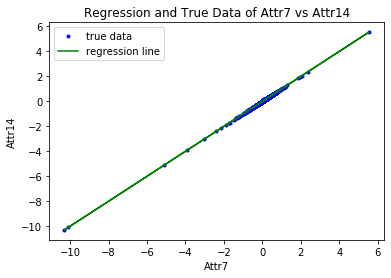

In [26]:
attr7_14_slope, attr7_14_incept = np.polyfit(df_NO.Attr7, df_NO.Attr14, 1)

plt.plot(df_NO.Attr7, df_NO.Attr14, marker='.', linestyle='none', color='blue', label='true data')
plt.plot(df_NO.Attr7, attr7_14_incept+df_NO.Attr7*attr7_14_slope, color='green', label='regression line')
plt.legend()
plt.xlabel('Attr7')
plt.ylabel('Attr14')
plt.title('Regression and True Data of Attr7 vs Attr14')

print('Slope = %f and y-intercept = %f' % (attr7_14_slope, attr7_14_incept))

Slope = 0.999995 and y-intercept = 0.000009


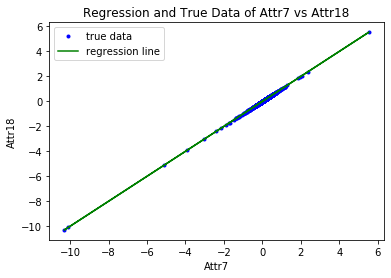

In [27]:
attr7_18_slope, attr7_18_incept = np.polyfit(df_NO.Attr7, df_NO.Attr18, 1)

plt.plot(df_NO.Attr7, df_NO.Attr18, marker='.', linestyle='none', color='blue', label='true data')
plt.plot(df_NO.Attr7, attr7_18_incept+df_NO.Attr7*attr7_18_slope, color='green', label='regression line')
plt.legend()
plt.xlabel('Attr7')
plt.ylabel('Attr18')
plt.title('Regression and True Data of Attr7 vs Attr18')

print('Slope = %f and y-intercept = %f' % (attr7_18_slope, attr7_18_incept))

Slope = 0.999982 and y-intercept = -0.000015


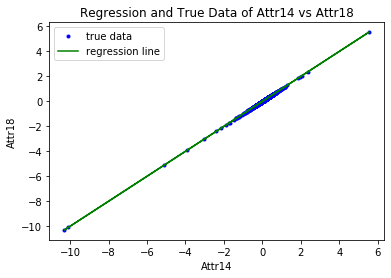

In [28]:
attr14_18_slope, attr14_18_incept = np.polyfit(df_NO.Attr14, df_NO.Attr18, 1)

plt.plot(df_NO.Attr14, df_NO.Attr18, marker='.', linestyle='none', color='blue', label='true data')
plt.plot(df_NO.Attr14, attr14_18_incept+df_NO.Attr14*attr14_18_slope, color='green', label='regression line')
plt.legend()
plt.xlabel('Attr14')
plt.ylabel('Attr18')
plt.title('Regression and True Data of Attr14 vs Attr18')

print('Slope = %f and y-intercept = %f' % (attr14_18_slope, attr14_18_incept))

The definitions for these financial attributes are below.  

Note: that EBIT = Gross profit – Operating expenses – SG&A – Depreciation(Amortization)

These are all proportional to gross profit/total sales.  Therefore, if the data for these attributes are essentially the same, it is very possible that companies are not accurately reporting interest, operating expenses, SG&A, and depreciation (and/or amortization).  More directly stated, companies may be reporting these financial metrics as zero.  This could significantly impact the decision of whether a company files for bankruptcy.

In addition, after further investigation is completed, it may be necessary to remove two of the three columns from the analysis.  columns that are so highly correlated to each other cause multicollinearity that can lead to overfitting of models and Type II errors.

In [29]:
same_column_check = df1[['Attr7','Attr14', 'Attr18']]
same_column = pd.DataFrame({'Definition':[finance_def_df.loc[i,'expression'] for i in same_column_check.columns[0:3]]},\
                           index=same_column_check.columns[0:3])
print(same_column)

                                      Definition
Attr7                        EBIT / total assets
Attr14  (gross profit + interest) / total assets
Attr18               gross profit / total assets


To conclude, early indications seem to point to an increase in the bankruptcy rate in Poland.  However, more statistical analyses are needed to confirm this hypothesis.  In addition, the inversely proportional relationship of total assets and sales may be important factors that influence the increase.  Finally, accurate reporting of financial data could be significant in determining if a company files for bankruptcy.

Future work will focus on if bankruptcies are statistically increasing in Poland and if we can predict whether a company will file for bankruptcy based on data from the financial attributes available to us.